In [1]:
import os 
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer




CODE_PATH = os.getcwd()
BASE_PATH = os.path.abspath(os.path.join(CODE_PATH, ".."))
DATA_PATH = os.path.join(BASE_PATH, "Data")
os.chdir(BASE_PATH)

## Load Data

In [2]:
#load data
data = pd.read_csv(os.path.join(DATA_PATH, 'Reviews.csv'))
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#select useful columns
cols = ['ProductId', 'UserId', 'Score', 'Text']
select_data = data[cols]
select_data.head()

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


## Preprocess Data

### Label Sentiment

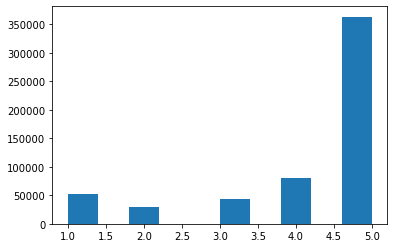

In [4]:
#visulize the distribution of scores
plt.hist(select_data["Score"])
plt.show()

In [5]:
#split the data
train_data, test_data = train_test_split(select_data, random_state=0, test_size=0.3)

In [6]:
sentiment_label = {1: "positive",
                 0: "neutral",
                 -1: "negative"}
def label_sentiment(data):
    data.loc[data['Score'] == 5, ["sentiment"]] = 1
    data.loc[data['Score'] == 4, ["sentiment"]] = 0
    data.loc[data['Score'] <= 3, ["sentiment"]] = -1
    return data


In [7]:
train_data = label_sentiment(train_data)
test_data = label_sentiment(test_data)
train_data.head()

,ProductId,UserId,Score,Text,sentiment
333546,B00188S3PM,A3IMFBFX5L85S9,2,I had a hard time drinking this tea as it tast...,-1.0
149769,B00004S1C5,A1KXONFPU2XQ5K,5,This are so much easier to use than the Wilson...,1.0
483649,B000LKTW5S,A2CH3AVJI0UR3P,5,I've had a bunch of these Indian food pouch th...,1.0
392300,B001EQ50U4,AKP5H95MFKI21,4,"I received this item as advertised, i.e. pack ...",0.0
1514,B003UIDAHY,A5WOFSMP2PI45,5,Great product. Recommended by Dr. Oz. We lov...,1.0


## Create document embeddings

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pre-trained model
senttrans_model = SentenceTransformer('all-MiniLM-L6-v2',device=device)

# Create embeddings for training set text
X_train = train_data['Text'].values.tolist()
X_train = [senttrans_model.encode(doc) for doc in X_train]

# Create embeddings for test set text
X_test = test_data['Text'].values.tolist()
X_test = [senttrans_model.encode(doc) for doc in X_test]

Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 587kB/s]
Downloading: 100%|██████████| 10.2k/10.2k [00:00<00:00, 5.09MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 58.0kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 1.05MB/s]
Downloading: 100%|██████████| 349/349 [00:00<00:00, 349kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:06<00:00, 14.1MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 23.5kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 112kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 3.01MB/s]
Downloading: 100%|██████████| 350/350 [00:00<00:00, 173kB/s]
Downloading: 100%|██████████| 13.2k/13.2k [00:00<00:00, 7.54MB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 1.88MB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 95.0kB/s]


## Train classification model

In [10]:
# Train a classification model using logistic regression classifier
y_train = train_data['sentiment']
logreg_model = LogisticRegression(solver='saga')
logreg_model.fit(X_train,y_train)
preds = logreg_model.predict(X_train)
acc = sum(preds==y_train)/len(y_train)
print('Accuracy on the training set is {:.3f}'.format(acc))

Accuracy on the training set is 0.739


## Evaluate model performance

In [11]:
# Evaluate performance on the test set
y_test = test_data['sentiment']
preds = logreg_model.predict(X_test)
acc = sum(preds==y_test)/len(y_test)
print('Accuracy on the test set is {:.3f}'.format(acc))

Accuracy on the test set is 0.737


In [13]:
train_data['sentiment_pred'] = logreg_model.predict(X_train)
test_data['sentiment_pred'] = logreg_model.predict(X_test)

In [14]:
train_data.head()

,ProductId,UserId,Score,Text,sentiment,sentiment_pred
333546,B00188S3PM,A3IMFBFX5L85S9,2,I had a hard time drinking this tea as it tast...,-1.0,1.0
149769,B00004S1C5,A1KXONFPU2XQ5K,5,This are so much easier to use than the Wilson...,1.0,1.0
483649,B000LKTW5S,A2CH3AVJI0UR3P,5,I've had a bunch of these Indian food pouch th...,1.0,1.0
392300,B001EQ50U4,AKP5H95MFKI21,4,"I received this item as advertised, i.e. pack ...",0.0,-1.0
1514,B003UIDAHY,A5WOFSMP2PI45,5,Great product. Recommended by Dr. Oz. We lov...,1.0,1.0


In [15]:
train_data.to_csv(os.path.join(DATA_PATH, "transformer_train.csv"))
test_data.to_csv(os.path.join(DATA_PATH, "transformer_test.csv"))